## Initialization
Import relevant packages

In [41]:
import os
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pylab as plt
import settree
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

## Create dataset
Create dataset from embeddings of data. 

In [3]:
df = pd.read_csv("/mnt/ncshare/ozkilim/BRCA/data/tasks/PTRC-HGSOC_reduced.csv") # list of data fro training with labels. 
folder_path = "/tank/WSI_data/Ovarian_WSIs/HGSOC_ovarian/CLAM/level_0/Ov_ViT/h5_files/" # dir to embeddings.

# Dictionary to store features
X = []
y = []
for index, row in tqdm(df.iterrows()):
    file_name = f"{row['slide_id']}.h5"
    file_path = os.path.join(folder_path, file_name)

    if os.path.exists(file_path):
        with h5py.File(file_path, 'r') as h5_file:
            # Assuming the features are stored under a key named 'features'
            features = np.array(h5_file['features']) 
            X.append(features)
            label = [1 if row["label"] == "sensitive" else 0] 
            y.append(label[0])
    else:
        print(f"File not found: {file_name}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# You can print X_train to see the structure. Its a list of numpy arrays (bags) shaped [n,d] where n is the number of objects in the bag and and d is the embddding dimention.

ds_train = settree.SetDataset(records=X_train, is_init=True)
ds_test = settree.SetDataset(records=X_test, is_init=True)

345it [01:56,  2.95it/s]


Configure the desired set-compatible split criteria for SetTree.

## Configure and train Set-Tree model

In [4]:
%time
# Model params
ATTN_SET_LIMIT = 1
USE_ATTN_SET = True
USE_ATTN_SET_COMP = True
MAX_DEPTH = 3
SEED = 0

set_tree_model = settree.SetTree(classifier=True,
                                 criterion='entropy',
                                 splitter='sklearn',
                                 max_features=None,
                                 min_samples_split=2,
                                 operations=settree.OPERATIONS,
                                 use_attention_set=USE_ATTN_SET,
                                 use_attention_set_comp=USE_ATTN_SET_COMP,
                                 attention_set_limit=ATTN_SET_LIMIT,
                                 max_depth=MAX_DEPTH,
                                 min_samples_leaf=None,
                                 random_state=SEED)

set_tree_model.fit(ds_train, np.array(y_train))
preds = set_tree_model.predict(ds_test)
auc = roc_auc_score(y_test, preds)

print('Set-Tree: Test AUC: {:.4f}'.format(auc))


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 8.82 µs
Set-Tree: Test AUC: 0.6737


## Visualize the heatmap of a sample

In [75]:
import openslide
import matplotlib.pyplot as plt

# Path to your WSI file
wsi_path = "/tank/WSI_data/Ovarian_WSIs/HGSOC_ovarian/slides/1009628_269137_ImageActual.svs"
# Open the WSI file
slide = openslide.OpenSlide(wsi_path)
# Get a thumbnail of the whole slide (adjust the size as needed)
thumbnail = slide.get_thumbnail(size=(800, 800))  # Width, Height in pixels

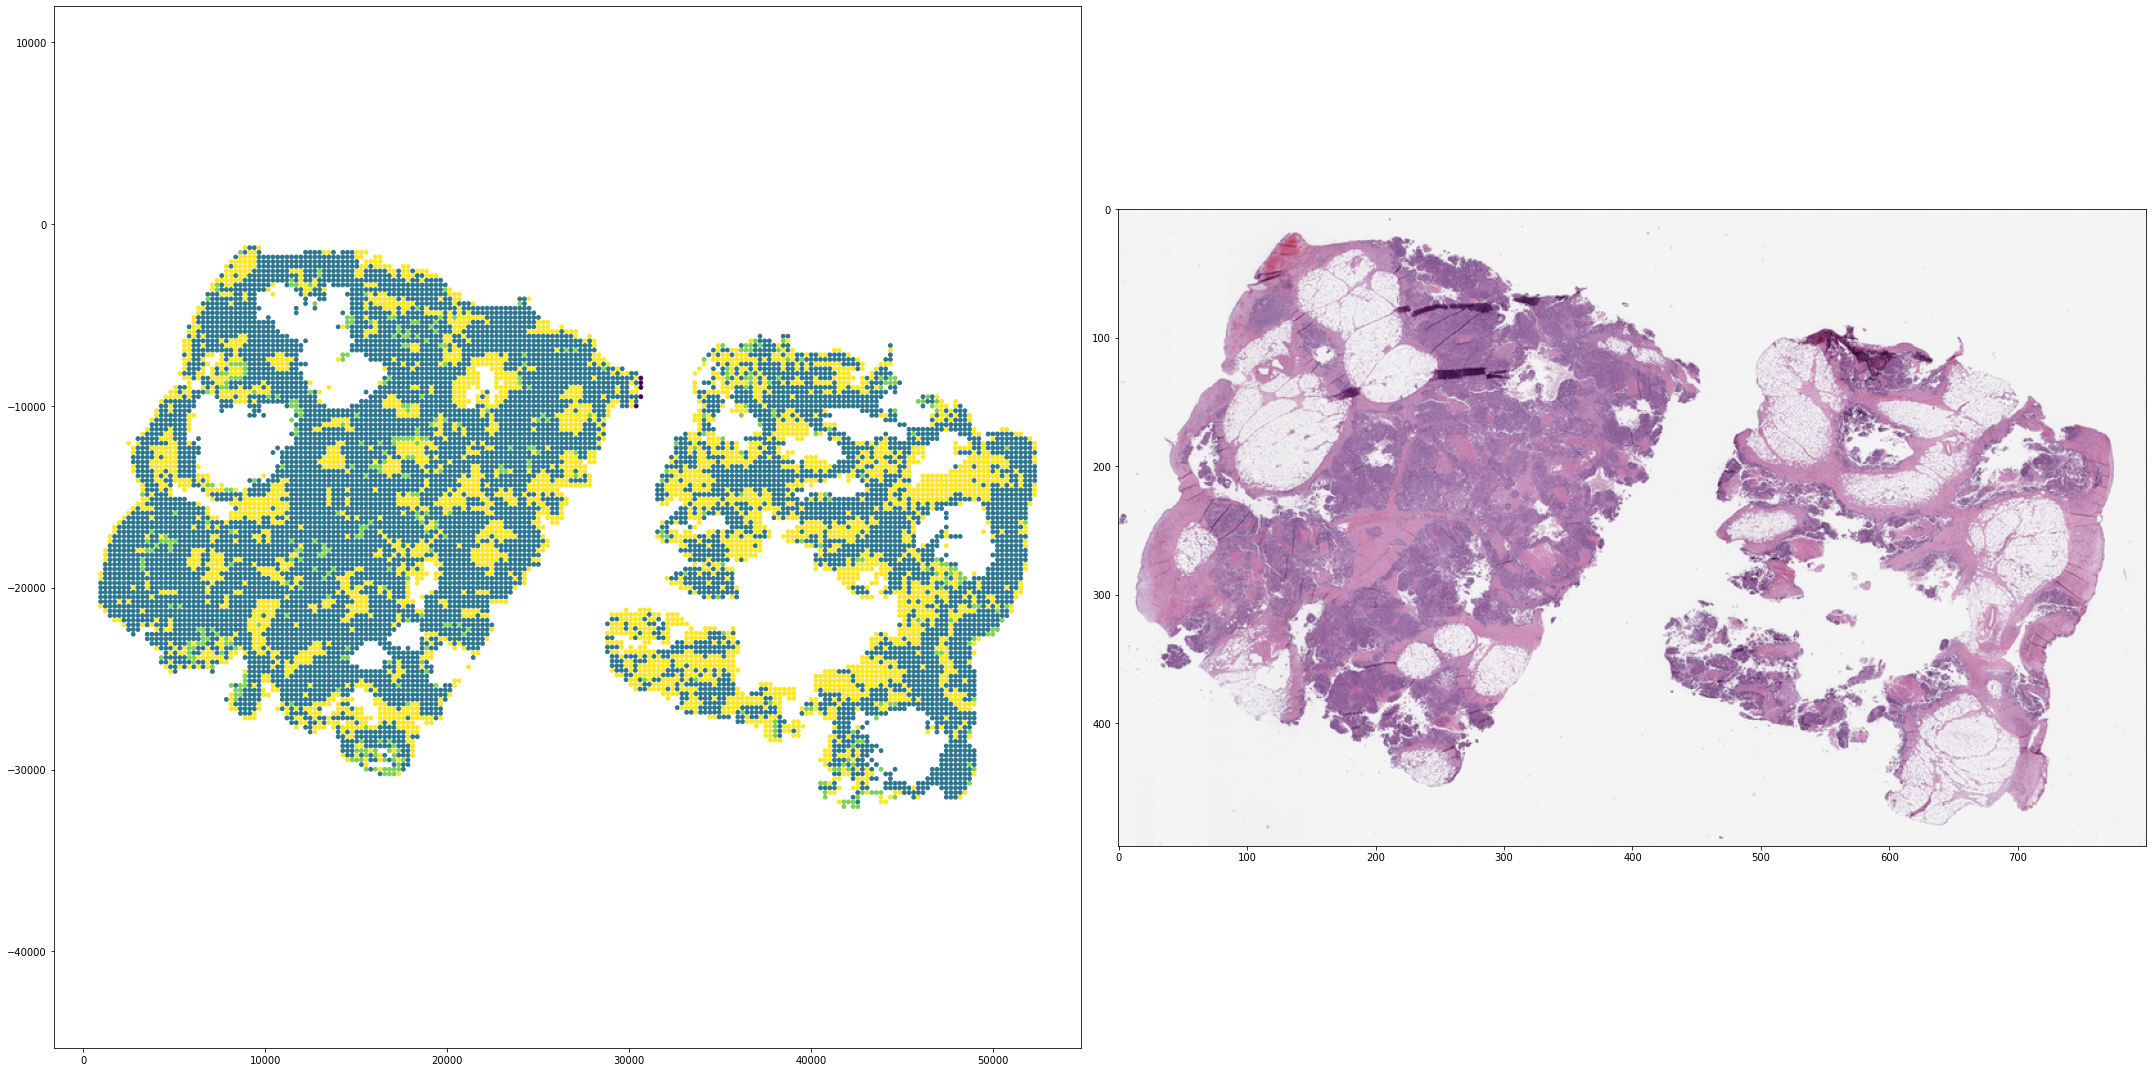

In [88]:
sample_record = X_test[0]
point2rank = settree.get_item2rank_from_tree(set_tree_model, settree.SetDataset(records=[sample_record], is_init=True))

test_h5 = "/tank/WSI_data/Ovarian_WSIs/HGSOC_ovarian/CLAM/level_0/Ov_ViT/h5_files/1009628_269137_ImageActual.h5"

with h5py.File(test_h5, 'r') as file:
    coords = np.array(file["coords"])


fig, axs = plt.subplots(1, 2, figsize=(30, 15))  # 1 row, 2 columns

attnetions = np.array(list(point2rank.values()))
attns = np.pad(attnetions, (0, 5), 'constant') # not sure why not same size ...?

axs[0].scatter(list(coords[:,0]),list(-coords[:,1]),c=attns/attns.max(),s=14)
axs[0].axis('equal')  # Make axes equal
axs[1].imshow(thumbnail)

# plot real image next to it...
plt.tight_layout()  # Adjust the layout
plt.show()

(array([7744.,    0.,    0.,    0.,    0.,    0.,  436.,    0.,    0.,
        3498.]),
 array([3871.5, 4477.2, 5082.9, 5688.6, 6294.3, 6900. , 7505.7, 8111.4,
        8717.1, 9322.8, 9928.5]),
 <BarContainer object of 10 artists>)

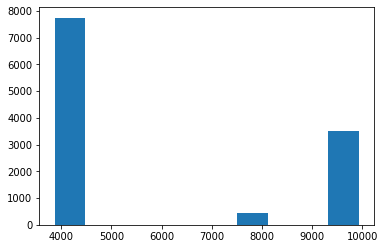

In [85]:
attnetions = np.array(list(point2rank.values()))
plt.hist(attnetions)